# Solución de problemas con pipelines - Preprocesamiento y búsqueda de hiperparámetros

En este tutorial aprenderás cómo crear pipelines para ejecutar todo el proceso de machine learning para el entrenamiento de un modelo de árboles de decisión. En ese sentido, realizarás la búsqueda de hiperparámetros y evaluarás el mejor modelo usando métricas de rendimiento para un problema de clasificación. Específicamente, verás cómo realizar los siguientes procesos:

1. Importar las librerías requeridas.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Definir los pasos del preprocesamiento de datos.
5. Realizar la búsqueda de hiperparámetros mediante un pipeline.
6. Evaluar el mejor modelo resultante.

En este tutorial seguiremos utilizando el conjunto de datos correspondiente a la compra de seguros de viaje. En este problema queremos predecir si una persona va a comprar un seguro de viaje dependiendo de factores como su edad, salario, educación, entre otros.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy` y `scikit-learn`. En particular, usaremos las siguientes clases y funciones para construir el pipeline, así como entrenar y evaluar el modelo de árboles de decisión:

* `Pipeline()`: clase para construir el pipeline.
* `SimpleImputer()`: clase para realizar la imputación de datos.
* `ColumnTransformer()`: clase para realizar transformaciones por columnas.
* `StandardScaler()` y `MinMaxScaler()`: clases para realizar la estandarización.
* `OneHotEncoder()`: clase para realizar la codificación OneHot.
* `DecisionTreeClassifier()`: clase para crear el modelo de árbol de decisión.
* `classification_report()`: función para obtener un reporte con las métricas de rendimiento por clase.
* `plot_confusion_matrix()`: función para graficar la matriz de confusión.

In [23]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [24]:
data_raw = pd.read_csv('data/TravelInsurancePrediction.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [25]:
data_raw.head()

,Index,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31.0,Government Sector,Yes,400000.0,6.0,1.0,No,No,0
1,1,31.0,Private Sector/Self Employed,Yes,1250000.0,7.0,0.0,No,No,0
2,2,34.0,Private Sector/Self Employed,Yes,500000.0,4.0,1.0,No,No,1
3,3,28.0,Private Sector/Self Employed,Yes,700000.0,3.0,1.0,No,No,0
4,4,28.0,Private Sector/Self Employed,Yes,700000.0,8.0,1.0,Yes,No,0


Como puedes observar, nuestro conjunto de datos contiene cinco variables categóricas: `Employment Type`, `GraduateOrNot`, `ChronicDiseases`, `FrequentFlyer` y `EverTravelledAbroad`.

## 3. Exploración del conjunto de datos

Utilizaremos `data_raw.describe()` para obtener una descripción de las variables numéricas del conjunto de datos. Ten en cuenta que esta función también incluye variables categóricas con clases numéricas:

In [26]:
data_raw.describe()

,Index,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1939.000000,1.937000e+03,1931.000000,1940.000000,1987.000000
mean,993.000000,29.670449,9.358286e+05,4.767996,0.278866,0.357323
std,573.741812,2.910996,3.762435e+05,1.614709,0.448557,0.479332
min,0.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,496.500000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,993.000000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1489.500000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1986.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


## 4. Definición de pasos del preprocesamiento de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [27]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para predecir si el cliente va a comprar un seguro de viajes: `Index`. Haciendo uso de la función `drop()`, eliminaremos esta variable del DataFrame:

In [28]:
data = data.drop('Index', axis=1)

### Tratamiento de nulos y duplicados

Veremos si hay duplicados utilizando `duplicated().sum()`:

In [29]:
data.duplicated().sum()

486

Podemos tratar directamente los datos duplicados antes de entrar al pipeline mediante la función `drop_duplicates()` de Pandas: 

In [30]:
data = data.drop_duplicates()

Adicionalmente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [31]:
data.isna().sum()

Age                    48
Employment Type        83
GraduateOrNot          65
AnnualIncome           48
FamilyMembers          51
ChronicDiseases        47
FrequentFlyer          90
EverTravelledAbroad    92
TravelInsurance         0
dtype: int64

En vez de eliminar estos datos, realizaremos una imputación para reemplazar los valores nulos por valores como la media, mediana, entre otros. En ese sentido, definiremos dos objetos de la clase `SimpleImputer()`, especificando que reemplazaremos los valores nulos por el valor más frecuente (para las variables categóricas) y por la media (para las variables numéricas):

In [32]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

Unificaremos estos objetos en un solo paso del pipeline mediante un objeto de la clase `ColumnTransformer()`, especificando dos arreglos con los índices de las variables numéricas y categóricas: 

In [33]:
# Variables Age, AnnualIncome, FamilyMembers
numeric_features = [0, 3, 4]
# Variables Employment Type, GraduateOrNot, ChronicDiseases, FrequentFlyer, EverTravelledAbroad
categorical_features = [1, 2, 5, 6, 7]

imputer = ColumnTransformer(
    transformers=[
        ("num", num_imputer, numeric_features),
        ("cat", cat_imputer, categorical_features)
    ]
)

### Transformación de variables categóricas

Como la implementación de `sklearn` necesita que todos los valores de las variables sean numéricos, incluiremos una codificación OneHot dentro del pipeline mediante un objeto de la clase `OneHotEncoder()`:

In [34]:
encoder = OneHotEncoder()

### Estandarización de variables numéricas

Igualmente, el modelo de árboles de decisión no necesita estandarizar las variables para realizar las particiones. Sin embargo, incluiremos un paso de estandarización por completitud de nuestro pipeline de preprocesamiento, haciendo uso de un objeto de la clase `StandardScaler()`: 

In [35]:
scaler = StandardScaler()

Ten en cuenta que el paso de imputación retorna un arreglo de `numpy` con un orden diferente: las variables numéricas están agrupadas en los primeros índices, seguidas de las variables categóricas. Utilizaremos un objeto de la clase `ColumnTransformer()` para especificar el tipo de transformación que se usará con cada conjunto de variables, teniendo en cuenta este nuevo orden:

In [36]:
# Variables Age, AnnualIncome, FamilyMembers
numeric_features = [0, 1, 2]
# Variables Employment Type, GraduateOrNot, ChronicDiseases, FrequentFlyer, EverTravelledAbroad
categorical_features = [3, 4, 5, 6, 7]

transformer = ColumnTransformer(
    transformers=[
        ("num", scaler, numeric_features),
        ("cat", encoder, categorical_features)
    ]
)

### División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función `train_test_split()`. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [37]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
857,28.0,Government Sector,Yes,600000.0,3.0,0.0,No,No,1
783,29.0,Private Sector/Self Employed,Yes,1100000.0,7.0,0.0,NaN,No,0
1326,34.0,Private Sector/Self Employed,Yes,700000.0,5.0,0.0,No,No,0
1780,31.0,Private Sector/Self Employed,Yes,950000.0,NaN,0.0,Yes,No,0
1424,31.0,Government Sector,Yes,400000.0,9.0,0.0,No,No,0


Además, separaremos la variable objetivo `TravelInsurance` de las variables descriptoras:

In [38]:
x_train = train.drop(['TravelInsurance'],axis=1)
y_train = train['TravelInsurance']

## 5. Búsqueda de hiperparámetros con un pipeline

Con el conjunto de datos modificado, crearemos un objeto de la clase `DecisionTreeClassifier()` que será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros:

In [39]:
decision_tree = DecisionTreeClassifier(random_state=0)

### Creación del pipeline

Siguiendo el concepto de transformadores y estimadores de `scikit-learn`, podemos incluir el preprocesamiento como los transformadores y el modelo como el estimador. Definiremos la secuencia de pasos que aplicaremos sobre el conjunto de datos utilizando tuplas de la forma `(nombre, objeto)`:

In [40]:
steps = [
    ("imputer", imputer),
    ("transformer", transformer),
    ("model", decision_tree),
]

Con la secuencia de pasos definida, crearemos un objeto de la clase `Pipeline()` para realizar la búsqueda:

In [41]:
pipeline = Pipeline(steps)

### Búsqueda de hiperparámetros

Uno de los beneficios de los pipelines es que podemos incluir otros parámetros diferentes a los del modelo dentro de la búsqueda de hiperparámetros. En ese sentido, utilizaremos los siguientes parámetros para realizar la búsqueda:

* **Estrategia de imputación (variables numéricas)**: utilizaremos la media y la mediana.
* **Estrategia de estandarización**: utilizaremos un objeto de la clase `StandardScaler()` y un objeto de la clase `MinMaxScaler()`.
* `criterion`: el criterio de pureza, que determina la calidad de una división. Utilizaremos dos de los más populares: la entropía y GINI.
* `max_depth`: la profundidad máxima del árbol. Este hiperparámetro se utiliza para el control de la complejidad del modelo.
* `min_samples_split`: número mínimo de datos necesarios en un nodo para poder definir una división.

Para especificar qué parámetro vamos a modificar en cada paso, utilizaremos la estructura `<paso>__<parámetro>` para definir las llaves del diccionario. En el caso de los `ColumnTransformer()`, que usan varios objetos en paralelo, utilizaremos la estructura `<transformer>__<objeto>__<parámetro>`. Incluso, podemos modificar los propios objetos del `ColumnTransformer()` mediante la estructura `<transformer>__<objeto>`:

In [42]:
param_grid = {
    # Paso de imputación
    'imputer__num__strategy': ['mean', 'median'],
    # Paso de transformación
    'transformer__num': [StandardScaler(), MinMaxScaler()],
    # Paso de modelado
    'model__criterion': ['entropy', 'gini'],
    'model__max_depth': [4, 6],
    'model__min_samples_split': [2, 3]
}

Al igual que en la búsqueda únicamente sobre los parámetros del modelo, definiremos un objeto de la clase `KFold()` para realizar la validación cruzada con 5 subconjuntos de datos:

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

Finalmente, definiremos la búsqueda con un objeto de la clase `GridSearchCV()` usando el pipeline `pipeline`, el espacio de búsqueda `param_grid` y la técnica de validación cruzada `kfold`:

In [44]:
grid = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda sobre el conjunto de entrenamiento original, que será modificado por el pipeline dependiendo de los pasos definidos para cada iteración:

In [45]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                                       missing_values=nan,
 

Ahora obtendremos los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [46]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'imputer__num__strategy': 'mean', 'model__criterion': 'entropy', 'model__max_depth': 4, 'model__min_samples_split': 2, 'transformer__num': StandardScaler(copy=True, with_mean=True, with_std=True)}


Como puedes ver, en términos de preprocesamiento se utiliza la media para la imputación y un `StandardScaler()` para la estandarización. Para el mejor modelo, se utiliza la entropía como criterio de pureza, una profundidad máxima de 4 y un mínimo de 2 datos para realizar una división. Almacenaremos el mejor modelo utilizando `grid.best_estimator_`:

In [47]:
mejor_modelo = grid.best_estimator_

## 6. Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [48]:
x_test = test.drop(['TravelInsurance'],axis=1)
y_test = test['TravelInsurance']

Incluso con los pasos de preprocesamiento integrados a nuestro modelo, podemos realizar predicciones sobre el conjunto de pruebas directamente mediante la función `predict()`:

In [49]:
y_pred = mejor_modelo.predict(x_test)

Ahora utilizaremos la función `plot_confusion_matrix()` para generar un mapa de calor con los valores de la matriz de confusión:

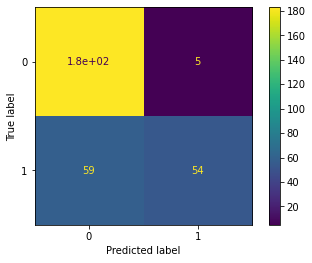

In [50]:
plot_confusion_matrix(mejor_modelo, x_test, y_test)

Como puedes observar, el modelo tiene el mismo comportamiento que el encontrado en la primera parte, con los mismos resultados de clasificación para ambas clases. Específicamente, podemos observar las métricas de desempeño usando `classification_report()`:

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       188
           1       0.92      0.48      0.63       113

    accuracy                           0.79       301
   macro avg       0.84      0.73      0.74       301
weighted avg       0.82      0.79      0.77       301



En este modelo se tienen valores altos en la sensibilidad de la clase 0. Como la clase 1 no tiene tanta representación, se tiene una sensibilidad bastante baja, aunque la precisión tiene un valor alto. Este valor de precisión indica que de los datos que el árbol clasifica en la clase 1 la mayoría realmente pertenecen a esta clase.